# 9.S52 Midterm Homework
### Jason Li
### Fall 2023

In this mini-project, I train a recurrent neural network (RNN) to maintain a stable "heading direction" while navigating towards a visual landmark, which represents insects being drawn towards certain visual landmarks like vertical bars in their visual field. Since I add noise to the action output, this also represents the drift robustness that many animals must implement when navigating in straight lines over long distances (particularly well studied in insect models). Finally, this RNN can also be taken as a rudimentary model of the function of the oculomotor integrator, which implements the vestibulo-ocular reflex by moving the eye in reponse to directional changes in real time.

In [38]:
import pickle
import os
import time
import math
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [39]:
device = 'cpu' #'cuda' if torch.cuda.is_available() else 'cpu'

In [40]:
# set training hyperparameters
BATCH_SIZE = 64
LEARNING_RATE = 0.0001
NUM_T = 30
FOV = 32

TRAIN_SAVES_DIR = 'train_saves'
SAVED_MODELS_DIR = 'saved_models'

if not os.path.exists(TRAIN_SAVES_DIR):
    os.makedirs(TRAIN_SAVES_DIR)
if not os.path.exists(SAVED_MODELS_DIR):
    os.makedirs(SAVED_MODELS_DIR)

Define the field of view, which we represent as a 1D line of 32 values representing the full angular space from 0 to 2 pi. The values represent visual intensity.

In [41]:
uniform_fov = torch.linspace(0, 2 * np.pi, FOV+1)[:-1].to(device)

To generate a batch for training, the inputs will be field of views as described above, with the "center" of the input (where intensity is highest, representing the visual landmark) shifted by a random amount. The desired output, or target, will be the angular shift required to move the landmark to the center of the field of view. This will be nontrivial and require multiple/infinite steps in time because noise will be added to the model's outputs.

In [42]:
def generate_batch(batch_size):
    thetas = (torch.rand(batch_size) * 2 * np.pi).to(device)
    coords = torch.meshgrid(thetas, uniform_fov)
    sads = torch.abs(torch.atan2(torch.sin(coords[0] - coords[1]), torch.cos(coords[0] - coords[1]))).to(device)
    inputs = torch.cos(sads)
    centers = (torch.zeros(batch_size) + np.pi).to(device)
    coords2 = torch.meshgrid(centers, uniform_fov)
    targets = torch.cos(torch.abs(torch.atan2(torch.sin(coords2[0] - coords2[1]), torch.cos(coords2[0] - coords2[1]))))
    return inputs.to(device), targets.to(device)

Given the current angular heading and a desired amount of angular shift, this helper function returns the new angluar heading and new field of view.

In [43]:
def shift_fov(curr_ang, shift):
    new_ang = curr_ang + shift.T[0]
    coords = torch.meshgrid(new_ang, uniform_fov)
    sads = torch.abs(torch.atan2(torch.sin(coords[0] - coords[1]), torch.cos(coords[0] - coords[1]))).to(device)
    new_fov = torch.cos(sads)
    return new_ang, new_fov

Define the model. We will run a standard feedforward neural net with tanh activation functions thru time as an RNN.

In [44]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.fc1 = nn.Linear(FOV * 2, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 8)
        self.fc4 = nn.Linear(8, 1)

    def forward(self, curr_fov, init_fov):
        x = F.tanh(self.fc1(torch.hstack((curr_fov, init_fov))))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

This function runs a single batch. Importantly, it adds noise to the output of the model at each time step.

In [45]:
def run_batch(action, rnn, inputs, targets, rnn_optimizer=None):
    """Train or test on a single batch."""
    with torch.set_grad_enabled(action == 'train'):
        if action == 'train':
            rnn_optimizer.zero_grad()
        loss = 0

        curr_fov = inputs
        curr_ang = torch.linspace(0, 2 * np.pi, BATCH_SIZE + 1)[:-1].to(device)

        # keep track of the foveas and angles
        fovs = [curr_fov.cpu().detach().numpy()]
        angles = [curr_ang.cpu().detach().numpy()]

        # for every time step
        for _ in range(NUM_T):
            # give the RNN the current foveal view and get the desired angular shift
            shift = rnn(curr_fov, inputs.detach())
            # ADD GAUSSIAN NOISE TO THE ANGULAR SHIFT
            shift += torch.normal(0, 0.1, (BATCH_SIZE, 1)).to(device)
            # shift the field of view by the noisy angular shift
            curr_ang, curr_fov = shift_fov(curr_ang, shift)

            fovs.append(curr_fov.cpu().detach().numpy())
            angles.append(curr_ang.cpu().detach().numpy())

            loss += torch.mean(torch.square(targets - curr_fov))

        # backpropagate losses
        if action == 'train':
            loss.backward()
            rnn_optimizer.step()

        return loss.item(), np.array(fovs), np.array(angles)

Training utilities:

In [46]:
def as_minutes(seconds):
    return '{:d}m {:d}s'.format(math.floor(seconds / 60), int(seconds - 60 * math.floor(seconds / 60)))


def train(rnn, learning_rate, batch_size, max_iters=5e6, print_every=200, test_every=1e13, save_every=1e13):
    train_losses, test_losses = [], []
    loss_buffer = 0

    rnn_optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

    print('Training')
    start_time = time.time()
    for curr_iter in range(1, int(max_iters) + 1):
        inputs, targets = generate_batch(batch_size)

        train_loss, fovs, angles = run_batch('train', rnn, inputs, targets, rnn_optimizer)
        loss_buffer += train_loss
        train_losses.append(train_loss)

        if curr_iter % print_every == 0:
            loss_avg = loss_buffer / print_every
            loss_buffer = 0
            time_elapsed = as_minutes(time.time() - start_time)
            print('{} ({:d} {:d}%) {:.4f}'.format(time_elapsed, curr_iter, round(curr_iter / max_iters * 100), loss_avg))

        if curr_iter % test_every == 0:
            test_loss, _, _, _ = run_batch('test', rnn, test_inputs, test_targets)
            test_losses.append(test_loss)
            print('Current Test Loss: {:.3f}'.format(test_loss))

        if curr_iter % save_every == 0:
            with open('{}/train_losses.pickle'.format(TRAIN_SAVES_DIR), 'wb') as f:
                pickle.dump(train_losses, f)
            with open('{}/val_losses.pickle'.format(TRAIN_SAVES_DIR), 'wb') as f:
                pickle.dump(test_losses, f)
            torch.save(rnn.state_dict(), '{}/rnn-it{}.pt'.format(SAVED_MODELS_DIR, curr_iter))

Finally, train and test the RNN:

In [47]:
rnn = RNN().to(device)
train(rnn, learning_rate=LEARNING_RATE, batch_size=BATCH_SIZE, max_iters=10000)

Training
0m 6s (200 2%) 16.1712
0m 15s (400 4%) 4.3044
0m 23s (600 6%) 3.6060
0m 31s (800 8%) 3.0597
0m 39s (1000 10%) 2.9724
0m 47s (1200 12%) 2.8676
0m 55s (1400 14%) 2.6062
1m 1s (1600 16%) 2.5311
1m 9s (1800 18%) 2.4461
1m 16s (2000 20%) 2.4309
1m 25s (2200 22%) 2.4259
1m 32s (2400 24%) 2.3390
1m 42s (2600 26%) 2.3339
1m 49s (2800 28%) 2.2992
1m 55s (3000 30%) 2.2539
2m 2s (3200 32%) 2.3415
2m 9s (3400 34%) 2.2740
2m 15s (3600 36%) 2.1676
2m 22s (3800 38%) 2.1804
2m 28s (4000 40%) 2.2620
2m 35s (4200 42%) 2.2274
2m 41s (4400 44%) 2.2007
2m 49s (4600 46%) 2.2074
2m 55s (4800 48%) 2.1558
3m 2s (5000 50%) 2.0588
3m 8s (5200 52%) 2.1190
3m 15s (5400 54%) 2.0696
3m 21s (5600 56%) 2.0379
3m 29s (5800 58%) 2.0560
3m 35s (6000 60%) 2.0389
3m 42s (6200 62%) 2.0223
3m 48s (6400 64%) 2.0589
3m 55s (6600 66%) 2.0334
4m 1s (6800 68%) 2.0572
4m 8s (7000 70%) 2.0401
4m 14s (7200 72%) 1.9988
4m 22s (7400 74%) 2.0115
4m 28s (7600 76%) 1.9869
4m 36s (7800 78%) 2.0007
4m 43s (8000 80%) 2.0034
4m 51s 

In [48]:
test_inputs, test_targets = generate_batch(BATCH_SIZE)
loss, fovs, angles = run_batch('test', rnn, test_inputs, test_targets)

Visualizations:

We can visualize the trajectories of the landmark as they start off-center but the RNN brings them to the center. The angle continues to oscillate around 0 because random noise is constantly being added to disrupt the RNN's centering. Each line in the plot is a different trial.

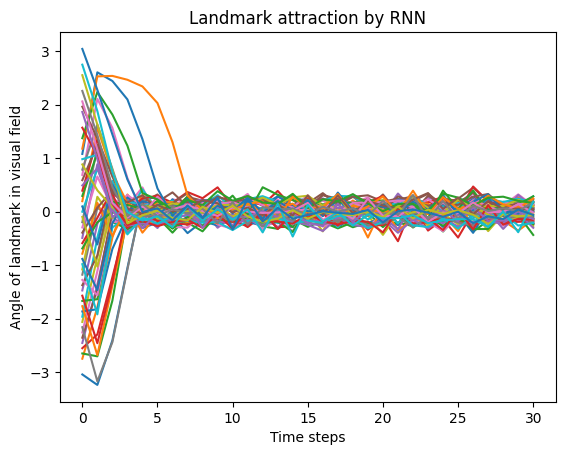

In [63]:
plt.title('Landmark attraction by RNN')
plt.xlabel('Time steps')
plt.ylabel('Angle of landmark in visual field')
plt.plot(angles[:, np.all(np.logical_and(angles < 8, angles > -2), axis=0)]-np.pi)
plt.show()

We can also visualize all of the fields of view in a single batch, at a single point in time. Here it is at time 0, when the model has yet to attempt to correct them:

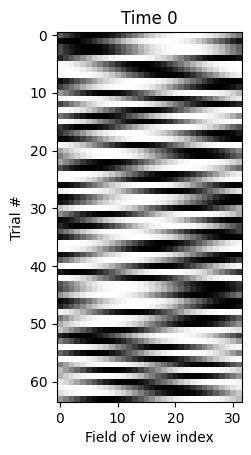

In [50]:
plt.title('Time 0')
plt.xlabel('Field of view index')
plt.ylabel('Trial #')
plt.imshow(fovs[0, :, :], cmap='Greys_r')
plt.show()

And here is the same plot at time 30, by which time the model has largely succeeded in aligning the brightest patches (landmarks) to the center of its field of view:

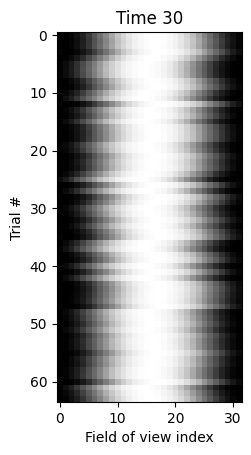

In [51]:
plt.title('Time 30')
plt.xlabel('Field of view index')
plt.ylabel('Trial #')
plt.imshow(fovs[30, :, :], cmap='Greys_r')
plt.show()